# Flipper-TR Membrane Tension Measurements
## Fluorescence Lifetime Imaging Microscopy Data Representation
October, 2024
Jack Crowley
<br>
This Notebook helps turn the intensity-encoded .tiff image and τ₂-lifetime-encoded .asc image into a color-coded image that uses a colorscale to encode lifetime and pixel lightness to encode the intensity.  I suggest using a perceptually-uniform ('isoluminant') colormap, as from colorcet.com, so that lightness adjustment is ~ orthoganal in colorspace to the color-coded axis.

In [1]:
# Imports
import numpy as np

import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable

import colorcet as cc

### USER INPUTS HERE

In [9]:
# Inputs
Int_fid = "D9_Adipo_OA_Dish01_11_intensity_image.tif"
T2_fid = "D9_Adipo_OA_Dish01_11_t2.asc"

# Colormap suggestions:  "cet_CET_I1", "cet_CET_I2", "cet_CET_I3", "cet_CET_R4", or "cet_bmy" from https://colorcet.com/
colormap = "cet_CET_I2"
c_minval = 2.5 # ns
c_maxval = 4.0 # ns

# Conversion factor for lifetime:  raw units / units in ns = ?  (1000 when lifetime in ps)
factor = 1000

#### Classes

In [3]:
# from TrailDreaming's response, https://stackoverflow.com/questions/26108436/how-can-i-get-the-matplotlib-rgb-color-given-the-colormap-name-boundrynorm-an
class MplColorHelper:

  def __init__(self, cmap_name, start_val=0, stop_val=255):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

#### Functions:  "Lifetime_Hist" & "Combined_FLIM_Image_Generator"

##### Combined_FLIM_Image_Generator
Inputs:
<br>Intensity_fname:     File location of Intensity .tiff file
<br>T2_fname:            File location of Tau-2 Lifetime .asc file
<br>colormap_name:       Colormap name (try "cet_CET_L7", "cet_CET_I1", "cet_CET_I2", "cet_CET_I3", "cet_CET_R4", or "cet_bmy")
<br>T2_cmap_min:         minimum lifetime component value for color range
<br>T2_cmap_max:         maximum lifetime component value for color range
<br><br>
Outputs:
<br>..._FLIM_IntensityImg.tif     Grayscale intensity image
<br>..._FLIM_GrayscaleT2.tif      Grayscale t2 lifetime image
<br>..._FLIM_ColorizedT2.tif      RGB t2 lifetime image, with applied colormap
<br>..._FLIM_ColorScale.tif         RGB t2 512x32 pixel color scale image
<br>..._FLIM_AnnotatedColorScale.tif     RGB t2 512x32 pixel color scale image with annotated divisions on side
<br>..._FLIM_Combined_IntensityT2.tif    RGB intensity- (lightness) and t2- (color) encoded image

In [14]:
# FLIM Histogram (unfiltered, but 0-ns bin is excluded from plot)
def Lifetime_Hist(T2_fname, T2_cmap_min=0, T2_cmap_max=10):
    # Step 1: Load ascii tabular data as a numpy array, convert to ns
    tau2_raw = np.genfromtxt(T2_fname, dtype=np.float32)/factor
                
    # Step 3: Tau2 Distribution Visualization (0 ns bin is excluded from plot)
    binwidth = (T2_cmap_max-T2_cmap_min)/256

    # Generate histogram of tau2 lifetimes
    hist, bins = np.histogram(tau2_raw, bins = [i*binwidth+T2_cmap_min for i in range(0,256)])

    # Plot distribution, sans first bin (which contains a significant fraction)
    fig = plt.figure(figsize=(7,2))
    plt.bar(bins[1:-1]+binwidth/2,hist[1:], width=binwidth, color='k')
    plt.xlabel('τ₂ Lifetime (ns)')
    plt.show()
    
    
    
# Combined FLIM Image Generator
def Combined_FLIM_Image_Generator(Intensity_fname, T2_fname, colormap_name="cet_CET_R4", T2_cmap_min=1, T2_cmap_max=6, save_opt=0):
    # Step 1: Create grayscale image
    intensity_img = cv2.imread(Intensity_fname)

    # Step 2: Create lifetime color map class instance
    tau2_color = MplColorHelper(colormap_name)

    # Step 3: Read in t2-encoded ascii image and convert to unsigned 8-bit integer format
    tau2_raw_img = np.genfromtxt(T2_fname, dtype=np.float32)/factor
    
    # Create empty 512x512 image, then populate with grayscale values, linearly interpolated from min to max lifetimes
    tau2_grayscale_image = np.zeros((512,512),np.uint8)

    for r in range(512):
        for c in range(512): # Since t2 & intensity are exported with mirrored column values, use inverted row index to align them
            # Many pixels don't have fitting data, leave these at "0 ns"
            if tau2_raw_img[-r][c] == 0:
                tau2_grayscale_image[r][c] = 0
            # Convert pixel range from raw data into 0-256 8-bit unsigned integer values for colormapping
            else:
                tau2_grayscale_image[r][c] = np.uint8(np.round( (255)*(tau2_raw_img[-r][c]-T2_cmap_min)/(T2_cmap_max-T2_cmap_min) ))

    # Step 4: Create lifetime images (grayscale and colorized)
    fig = plt.figure(figsize=(20,10))
    
    #         Configure 5 axes in subplots for simple visualization
    gs  = mpl.gridspec.GridSpec(1, 5, figure=fig, width_ratios=[100,100,100,100,5.5], left=0, right=1, bottom=0, top=1)
    ax0 = fig.add_subplot(gs[0]) # Axis for intensity grayscale image
    ax1 = fig.add_subplot(gs[1]) # Axis for tau2 8-bit grayscale image
    ax2 = fig.add_subplot(gs[2]) # Axis for tau2 colormapped image
    ax3 = fig.add_subplot(gs[3]) # Axis for dual-encoded intensity & lifetime image
    ax4 = fig.add_subplot(gs[4]) # Axis for tau2 color scale bar
    
    ax0.imshow(intensity_img)
    ax0.axis('off')
    ax0.set_title('Intensity')
    
    tau2_rgba_img = np.zeros((512,512,4), np.uint8)
    tau2_rgba_img[:,:] = tuple(i*255 for i in tau2_color.get_rgb(tau2_grayscale_image))
    
    tau2_rgb_img = np.zeros((512,512,3), np.uint8)
    tau2_rgb_img[:,:] = tuple(i for i in tau2_rgba_img[:,:,:3])
    
    ax1.imshow(tau2_grayscale_image, cmap='gray')
    ax1.axis('off')
    ax1.set_title('τ₂')
    
    ax2.imshow(tau2_rgb_img)
    ax2.axis('off')
    ax2.set_title(f'{colormap_name}  τ₂')
    
    
    # Step 5: Using colorspace transforms, adjust lightness/lumos of colorized lifetime image to encode intensity
    desired_lightness = intensity_img[:,:,0]
    
    tau2_hls_img = cv2.cvtColor(tau2_rgb_img, cv2.COLOR_RGB2HLS)
    
    combined_hls_img = tau2_hls_img
    combined_hls_img[:,:,1] = desired_lightness
    combined_rgb_img = cv2.cvtColor(combined_hls_img, cv2.COLOR_HLS2RGB)
    
    ax3.imshow(combined_rgb_img)
    ax3.axis('off')
    ax3.set_title('Combined Intensity & τ₂ Image')
    
    
    # Step 6: Generate Color Bars (512x20 pixels)
    ColorBar = np.zeros((512,20,3), np.uint8)
    for r in [i for i in range(0,512,1)]:
        for c in range(20):
            ColorBar[r][c] = np.floor((511-r)/2)
            
    ColorBar_rgba = np.zeros((512,20,4), np.uint8)
    ColorBar_rgba[:,:] = tuple(i*255 for i in tau2_color.get_rgb(ColorBar[:,:,0]))
    
    ColorBar_rgb = np.zeros((512,20,3), np.uint8)
    ColorBar_rgb[:,:] = tuple(i for i in ColorBar_rgba[:,:,:3])
    
    ax4.imshow(ColorBar_rgb)
    ax4.axis('off')
    ax4.annotate(f'{T2_cmap_max} ns', xy=(0, 12), xycoords='data', xytext=(30,12), size=12, va='center', ha='left')
    ax4.annotate(f'{T2_cmap_min} ns', xy=(0,500), xycoords='data', xytext=(30,500), size=12, va='center', ha='left')
    
    ax4.plot([-3, 23], [0, 0], 'k-', linewidth=0.8)
    ax4.plot([-3, 23], [1/4*512, 1/4*512], 'k-', linewidth=0.8)
    ax4.plot([-3, 23], [2/4*512, 2/4*512], 'k-', linewidth=0.8)
    ax4.plot([-3, 23], [3/4*512, 3/4*512], 'k-', linewidth=0.8)
    ax4.plot([-3, 23], [512, 512], 'k-', linewidth=0.8)
    
    plt.show()
    
    if save_opt:
        # Step 7: Save output files
        prefix = T2_fid[:-7] # just remove "_t2.asc"
        outfile_1 = prefix + "_FLIM_IntensityImg.png"
        outfile_2 = prefix + "_FLIM_GrayscaleT2.png"
        outfile_3 = prefix + "_FLIM_ColorizedT2.png"
        outfile_4 = prefix + "_FLIM_ColorScale.png"
        outfile_5 = prefix + "_FLIM_AnnotatedColorScale.png"
        outfile_6 = prefix + "_FLIM_Combined_IntensityT2.png"

        fig_1 = plt.subplots(figsize=(5,5))
        plt.imshow(intensity_img)
        plt.axis('off')
        plt.savefig(outfile_1)

        fig_2 = plt.subplots(figsize=(5,5))
        plt.imshow(tau2_grayscale_image, cmap='gray')
        plt.axis('off')
        plt.savefig(outfile_2)

        fig_3 = plt.subplots(figsize=(5,5))
        plt.imshow(tau2_rgb_img)
        plt.axis('off')
        plt.savefig(outfile_3)
        
        fig_4 = plt.subplots(figsize=(5,5))
        plt.imshow(ColorBar_rgb)
        plt.axis('off')
        plt.savefig(outfile_4)
        
        fig_5 = plt.subplots(figsize=(5,5))
        plt.imshow(ColorBar_rgb)
        plt.axis('off')
        plt.annotate(f'{T2_cmap_max} ns', xy=(0, 12), xycoords='data', xytext=(30,12), size=12, va='center', ha='left')
        plt.annotate(f'{T2_cmap_min} ns', xy=(0,500), xycoords='data', xytext=(30,500), size=12, va='center', ha='left')
        plt.plot([-3, 23], [0, 0], 'k-', linewidth=0.8)
        plt.plot([-3, 23], [1/4*512, 1/4*512], 'k-', linewidth=0.8)
        plt.plot([-3, 23], [2/4*512, 2/4*512], 'k-', linewidth=0.8)
        plt.plot([-3, 23], [3/4*512, 3/4*512], 'k-', linewidth=0.8)
        plt.plot([-3, 23], [512, 512], 'k-', linewidth=0.8)
        plt.savefig(outfile_5)
        
        fig_6 = plt.subplots(figsize=(5,5))
        plt.imshow(combined_rgb_img)
        plt.axis('off')
        plt.savefig(outfile_6)

### Function Calls

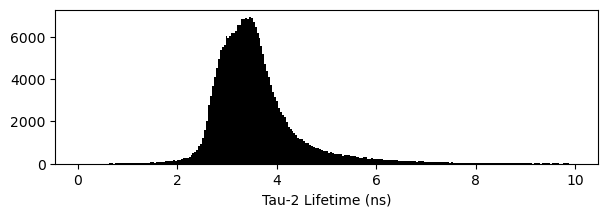

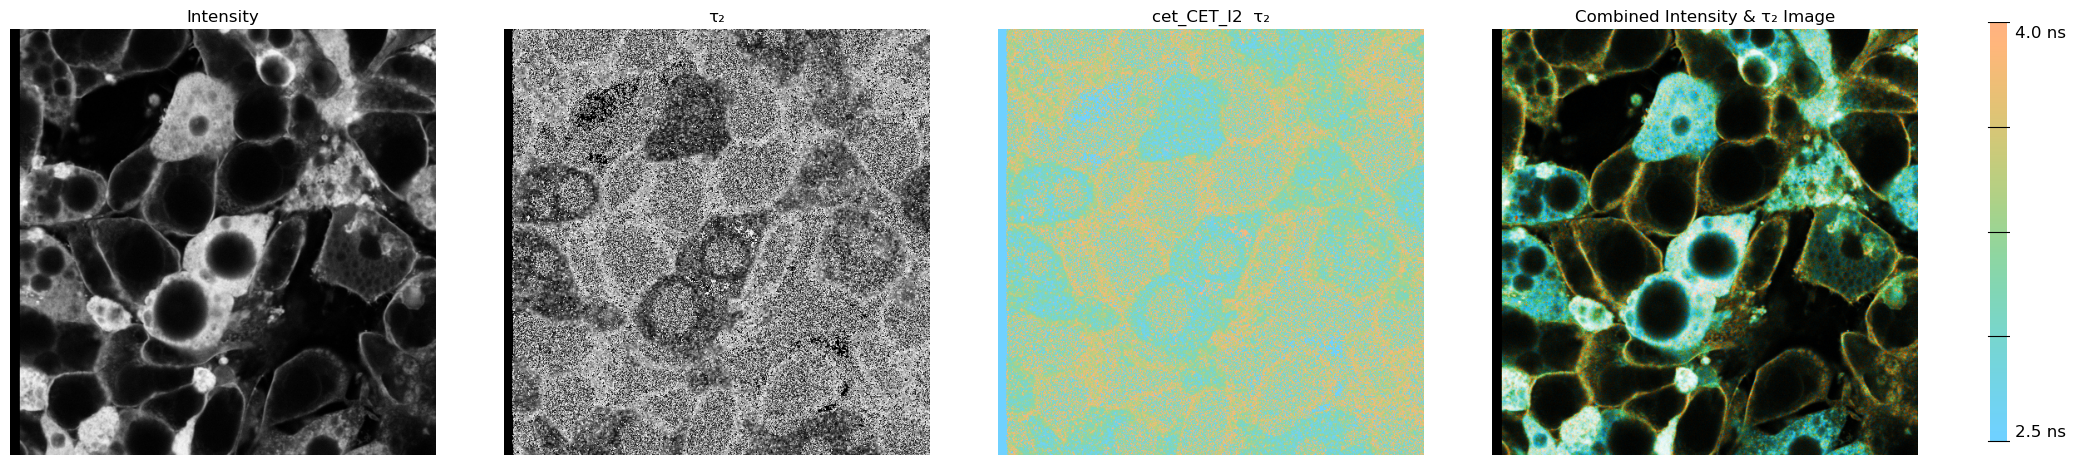

In [7]:
# OUTPUT
Lifetime_Hist(T2_fid)
Combined_FLIM_Image_Generator(Int_fid, T2_fid, colormap, c_minval, c_maxval, save_opt=0)

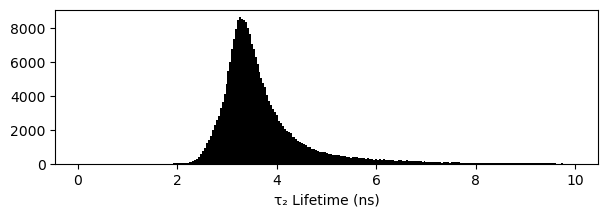

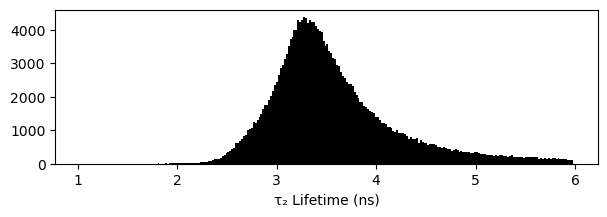

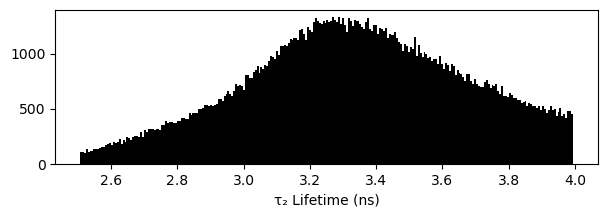

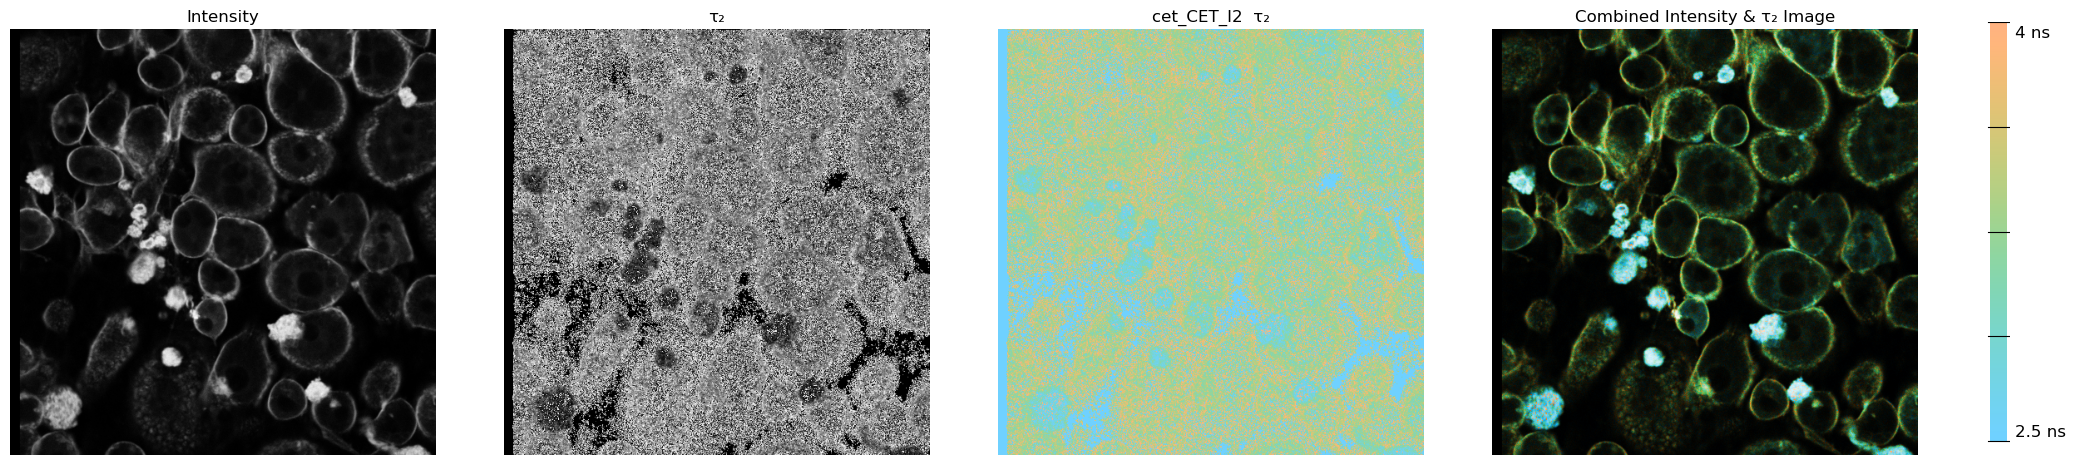

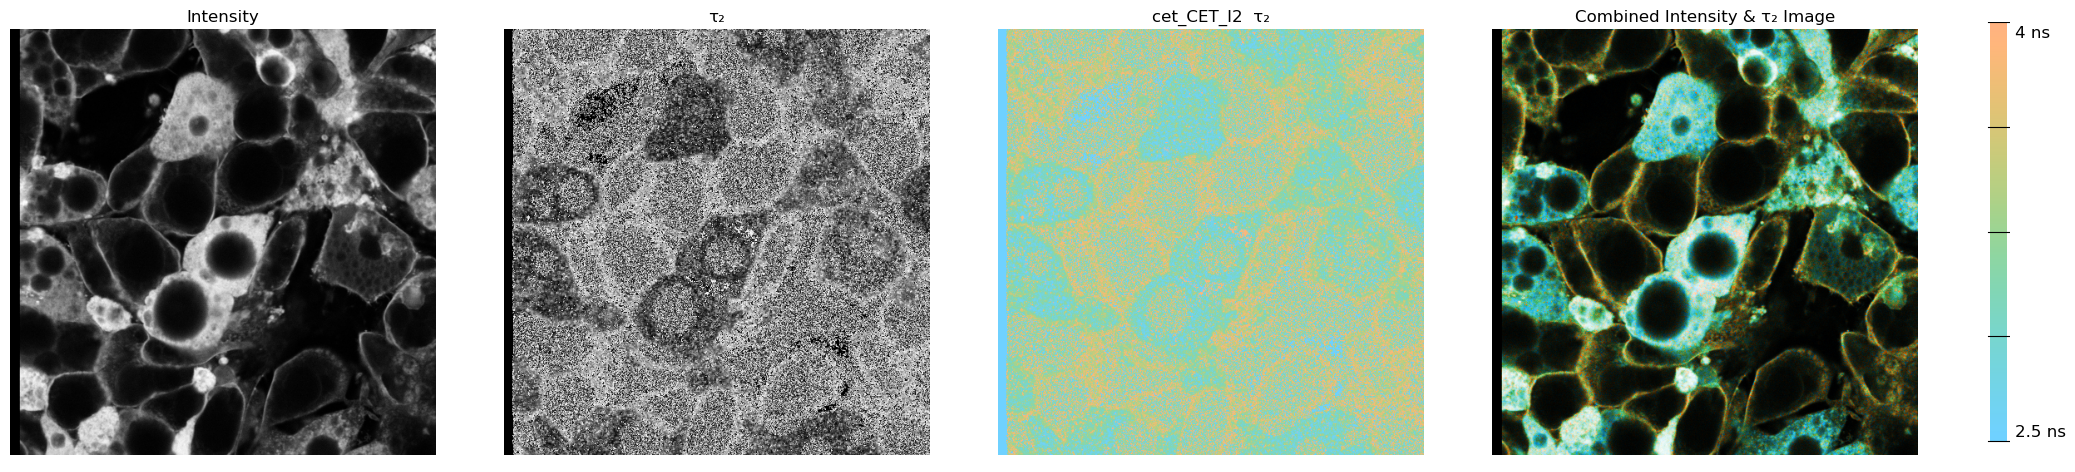

In [15]:
# SANDBOX
Lifetime_Hist(T2_fid)
Lifetime_Hist(T2_fid, 1, 6)
Lifetime_Hist(T2_fid, 2.5, 4)
    
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_I3')
Combined_FLIM_Image_Generator("D9_Adipo_Veh_Dish01_07_intensity_image.tif", "D9_Adipo_Veh_Dish01_07_t2.asc", 'cet_CET_I2', 2.5, 4, save_opt=0)
Combined_FLIM_Image_Generator("D9_Adipo_OA_Dish01_11_intensity_image.tif", "D9_Adipo_OA_Dish01_11_t2.asc", 'cet_CET_I2', 2.5, 4, save_opt=0)
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_I2')
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_I2', 2.5, 4)
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_L7')
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_L7', 2.5, 4)
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_R4')
#Combined_FLIM_Image_Generator(Int_fid, T2_fid, 'cet_CET_R4', 2.5, 4)